# Data Imports

In [5]:
import pickle
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import re
import matplotlib.pyplot as plt
import scipy.stats as st

In [6]:
def ks_plot_comp(data_1, data_2):
    plt.figure(figsize=(12, 7))
    plt.scatter(data_1, range(len(data_1)), label="base loss", alpha=0.3, s=2)
    plt.scatter(data_2, range(len(data_2)), label="attack loss", alpha=0.3, s=2)
    plt.legend('top right')
    plt.title('Comparing 2 data distributions for KS-Test')
    plt.show()

In [7]:
def batch_pvals(loss1, loss2):
    batch_size = 16
    stats = []
    pvals = []
    # for i in range(0, min(len(loss1), len(loss2)), batch_size):
    #     loss_batch1 = loss1[i:i+batch_size]
    #     loss_batch2 = loss2[i:i+batch_size]
    #     result = ks_2samp(loss_batch1, loss_batch2, alternative="greater")
    #     stats.append(result[0])
    #     pvals.append(result[1])
    # return stats, pvals

    for i in range(0, len(loss2), batch_size):
        loss_batch2 = loss2[i:i+batch_size]
        result = ks_2samp(loss1, loss_batch2, alternative="greater")
        stats.append(result[0])
        pvals.append(result[1])
    return stats, pvals

# TODO: LOSS1 should use whole distribution instead of iterating

# FGSM4

## CDF of KS Test

In [8]:
with open("output/base_loss.pkl", "rb") as f:
    base_loss_values = pickle.load(f)\

with open("output/fgsm4_mixed2.pkl", "rb") as f:
    fgsm4_mixed = pickle.load(f)

with open("output/fgsm4_loss.pkl", "rb") as f:
    fgsm4_clean = pickle.load(f)

In [9]:
samp_a = np.sort(base_loss_values)
samp_b = np.sort(fgsm4_mixed)

In [10]:
concat_samples = np.sort(np.concatenate((samp_a, samp_b)))

In [11]:
samp_a_cdf = [np.round(st.percentileofscore(samp_a, value)/100, 1) for value in concat_samples]
samp_b_cdf = [np.round(st.percentileofscore(samp_b, value)/100, 1) for value in concat_samples]
samp_diff = np.abs(np.subtract(samp_a_cdf, samp_b_cdf))

In [12]:
print(max(samp_diff))

0.30000000000000004


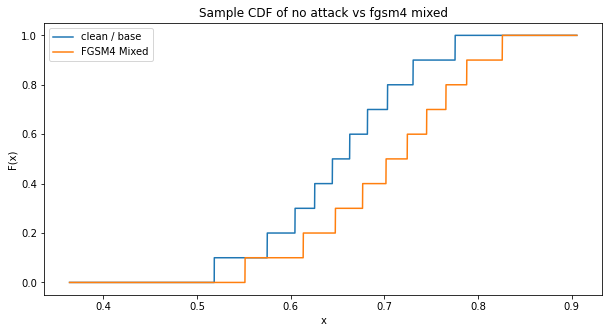

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(concat_samples, samp_a_cdf, label='clean / base')
plt.plot(concat_samples, samp_b_cdf, label='FGSM4 Mixed')

# for val, p1, p2 in zip(concat_samples, samp_a_cdf, samp_b_cdf):
#     plt.plot([val, val], [p1, p2], color='green', alpha=0.2)

plt.legend()
plt.ylabel("F(x)")
plt.xlabel('x')
plt.title("Sample CDF of no attack vs fgsm4 mixed")

plt.show()

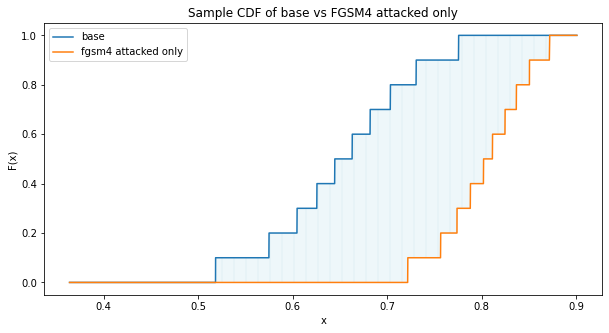

In [20]:
concat_samples = np.sort(np.concatenate((samp_a, np.sort(fgsm4_clean))))

samp_a_cdf = [np.round(st.percentileofscore(samp_a, value)/100, 1) for value in concat_samples]
samp_b_cdf = [np.round(st.percentileofscore(np.sort(fgsm4_clean), value)/100, 1) for value in concat_samples]
samp_diff = np.abs(np.subtract(samp_a_cdf, samp_b_cdf))

plt.figure(figsize=(10, 5))
plt.plot(concat_samples, samp_a_cdf, label='base')
plt.plot(concat_samples, samp_b_cdf, label='fgsm4 attacked only')

# for val, p1, p2 in zip(concat_samples, samp_a_cdf, samp_b_cdf):
#     plt.plot([val, val], [p1, p2], color='green', alpha=0.2)

plt.fill_between(concat_samples, samp_a_cdf, samp_b_cdf, color="lightblue", alpha=0.2, hatch="|")

plt.legend()
plt.ylabel("F(x)")
plt.xlabel('x')
plt.title("Sample CDF of base vs FGSM4 attacked only")

plt.show()

## ROC curve of model

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

In [62]:
X_train = np.concatenate((samp_a, samp_b))
X_train = np.vstack((X_train, np.ones(len(X_train))))

y_train = np.concatenate((np.zeros(len(samp_a)), np.ones(len(samp_b))))

In [63]:
X_train

array([[0.3638, 0.3638, 0.3676, ..., 0.9052, 0.9056, 0.9056],
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ]])

In [64]:
y_train.shape

(150000,)

In [65]:
X_train.shape

(2, 150000)

In [66]:
clf_reg = LogisticRegression()
clf_reg.fit(X_train.transpose(), y_train)

LogisticRegression()

In [67]:
proba = clf_reg.predict_proba(X_train.transpose())[:,1]

In [68]:
fpr, tpr, threshold = roc_curve(y_train, proba)

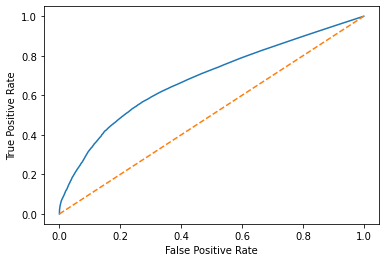

In [69]:
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Batch Threshold

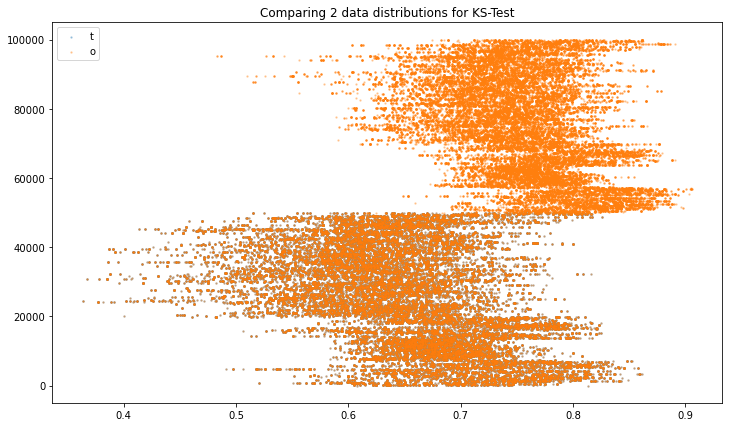

In [70]:
ks_plot_comp(base_loss_values, fgsm4_mixed)

In [8]:
# true_vals = np.concatenate((np.zeros(len(base_loss_values) // 16 // 2), np.ones((len(fgsm4_mixed) - len(base_loss_values)) // 16 // 2)))
# true_vals

array([0., 0., 0., ..., 1., 1., 1.])

In [71]:
fgsm4_clean = fgsm4_mixed[:len(base_loss_values)]
fgsm4_attacked = fgsm4_mixed[len(base_loss_values):]

In [72]:
s1, p1 = batch_pvals(base_loss_values, fgsm4_clean)
s2, p2 = batch_pvals(base_loss_values, fgsm4_attacked)

In [73]:
p_cutoff = 0.05
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

1296 1829 3073 52
accuracy:  0.69904


In [74]:
p_cutoff = 0.01
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

1540 1585 3024 101
accuracy:  0.73024


In [75]:
p_cutoff = 0.000001
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

2387 738 2657 468
accuracy:  0.80704


# PGDl2

## Batch Losses

In [1]:
with open("output/base_loss.pkl", "rb") as f:
    base_loss_values = pickle.load(f)

with open("output/pgdl2_mixed2.pkl", "rb") as f:
    pgdl2_mixed = pickle.load(f)

NameError: name 'pickle' is not defined

## CDF of KS Test

In [2]:
samp_a = np.sort(base_loss_values)

samp_b_clean = np.sort(pgdl2_mixed[0:len(samp_a)])
samp_b_attack = np.sort(pgdl2_mixed[len(samp_a):])
samp_b = np.sort(pgdl2_mixed)

NameError: name 'np' is not defined

In [3]:
plt.plot(pgdl2_mixed[0:len(samp_a)])
plt.plot(pgdl2_mixed[len(samp_a):])

NameError: name 'plt' is not defined

In [4]:
concat_samples = np.sort(np.concatenate((samp_a, samp_b)))
samp_a_cdf = [np.round(st.percentileofscore(samp_a, value)/100, 1) for value in concat_samples]
samp_b_cdf = [np.round(st.percentileofscore(samp_b, value)/100, 1) for value in concat_samples]
samp_diff = np.abs(np.subtract(samp_a_cdf, samp_b_cdf))
print(max(samp_diff))

NameError: name 'np' is not defined

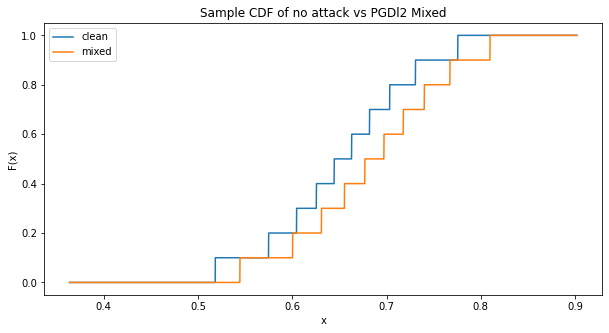

In [80]:
plt.figure(figsize=(10, 5))
plt.plot(concat_samples, samp_a_cdf, label='clean')
plt.plot(concat_samples, samp_b_cdf, label='mixed')

# for val, p1, p2 in zip(concat_samples, samp_a_cdf, samp_b_cdf):
#     plt.plot([val, val], [p1, p2], color='green', alpha=0.2)

plt.legend()
plt.ylabel("F(x)")
plt.xlabel('x')
plt.title("Sample CDF of no attack vs PGDl2 Mixed")

plt.show()

## ROC curve of model

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

In [82]:
X_train = np.concatenate((samp_a, samp_b))
X_train = np.vstack((X_train, np.ones(len(X_train))))

# not clean, sample b is mixed attack, sample a is base_loss
# y_train = np.concatenate((np.zeros(len(samp_a)), np.ones(len(samp_b))))

# cleaned
y_train = np.concatenate((np.zeros(len(samp_a) + len(samp_b_clean)), np.ones(len(samp_b_attack))))

In [83]:
X_train

array([[0.3638, 0.3638, 0.3676, ..., 0.9019, 0.9019, 0.9019],
       [1.    , 1.    , 1.    , ..., 1.    , 1.    , 1.    ]])

In [84]:
y_train.shape

(150000,)

In [85]:
X_train.shape

(2, 150000)

In [86]:
clf_reg = LogisticRegression()
clf_reg.fit(X_train.transpose(), y_train)

LogisticRegression()

In [87]:
proba = clf_reg.predict_proba(X_train.transpose())[:,1]
fpr, tpr, threshold = roc_curve(y_train, proba)

In [88]:
ks_2samp(base_loss_values, [0.8])

KstestResult(statistic=0.98108, pvalue=0.037840000000000096)

In [89]:
ks_2samp(base_loss_values, [0.5])

KstestResult(statistic=0.9686, pvalue=0.06279999999999997)

In [90]:
ks_2samp(base_loss_values, [0.55])

KstestResult(statistic=0.90332, pvalue=0.19335999999999998)

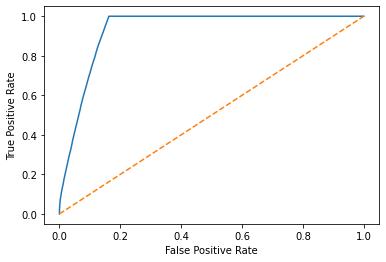

In [91]:
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

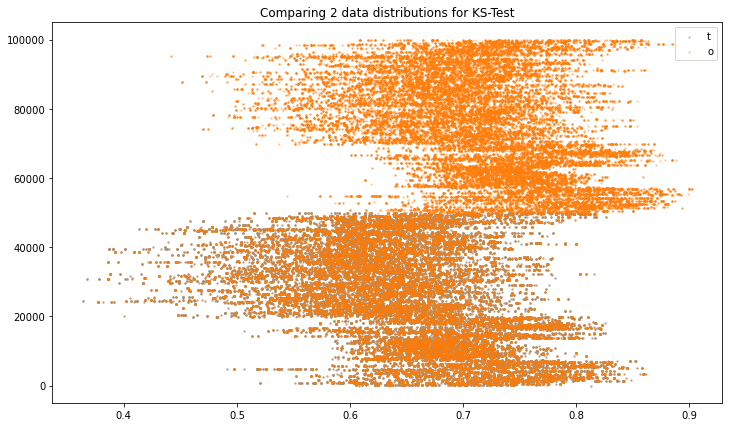

In [92]:
ks_plot_comp(base_loss_values, pgdl2_mixed)

## Batch Threshold

In [93]:
# true_vals = np.concatenate((np.zeros(len(base_loss_values) // 16 // 2), np.ones(len(pgdl2_mixed[len(base_loss_values) // 2 : 3 * len(base_loss_values) // 2]) // 16 // 2)))
# true_vals

In [94]:
pgdl2_clean = pgdl2_mixed[:len(base_loss_values)]
pgdl2_attacked = pgdl2_mixed[len(base_loss_values):]

In [95]:
s1, p1 = batch_pvals(base_loss_values, pgdl2_clean)
s2, p2 = batch_pvals(base_loss_values, pgdl2_attacked)

In [96]:
p_cutoff = 0.05
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

1296 1829 2700 425
accuracy:  0.63936


In [97]:
p_cutoff = 0.01
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

1540 1585 2548 577
accuracy:  0.65408


In [98]:
p_cutoff = 0.000001
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

2387 738 1818 1307
accuracy:  0.6728


# APGD

## Batch Losses

In [99]:
with open("output/base_loss.pkl", "rb") as f:
    base_loss_values = pickle.load(f)

with open("output/apgd_mixed.pkl", "rb") as f:
    apgd_mixed = pickle.load(f)

## CDF of KS Test

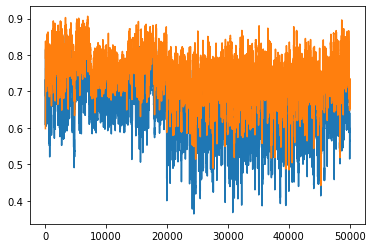

In [100]:
plt.plot(apgd_mixed[0:len(base_loss_values)])
plt.plot(apgd_mixed[len(base_loss_values):])

In [101]:
samp_a = np.sort(base_loss_values)

samp_b_clean = np.sort(apgd_mixed[0:len(samp_a)])
samp_b_attack = np.sort(apgd_mixed[len(samp_a):])
samp_b = np.sort(apgd_mixed)

In [102]:
concat_samples = np.sort(np.concatenate((samp_a, samp_b)))

In [103]:
samp_a_cdf = [np.round(st.percentileofscore(samp_a, value)/100, 1) for value in concat_samples]
samp_b_cdf = [np.round(st.percentileofscore(samp_b, value)/100, 1) for value in concat_samples]
samp_diff = np.abs(np.subtract(samp_a_cdf, samp_b_cdf))

In [104]:
print(max(samp_diff))

0.30000000000000004


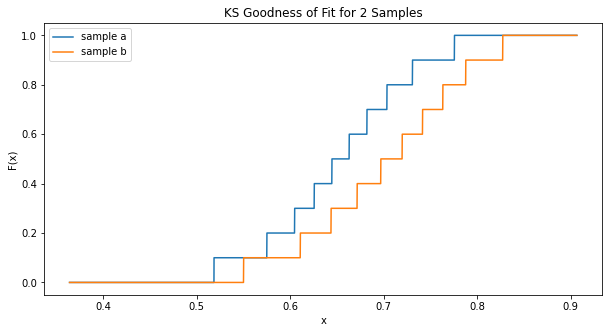

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(concat_samples, samp_a_cdf, label='sample a')
plt.plot(concat_samples, samp_b_cdf, label='sample b')

# for val, p1, p2 in zip(concat_samples, samp_a_cdf, samp_b_cdf):
#     plt.plot([val, val], [p1, p2], color='green', alpha=0.2)

plt.legend()
plt.ylabel("F(x)")
plt.xlabel('x')
plt.title("KS Goodness of Fit for 2 Samples")

plt.show()

## ROC curve of model

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

In [112]:
X = np.concatenate((samp_a, samp_b))
X = np.vstack((X, np.ones(len(X)))).transpose()

# not clean
# y = np.concatenate((np.zeros(len(samp_a)), np.ones(len(samp_b))))

# cleaned
y = np.concatenate((np.zeros(len(samp_a) + len(samp_b_clean)), np.ones(len(samp_b_attack))))

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=88, test_size=0.2)

In [114]:
X_train

array([[0.8672, 1.    ],
       [0.6871, 1.    ],
       [0.7287, 1.    ],
       ...,
       [0.7002, 1.    ],
       [0.719 , 1.    ],
       [0.763 , 1.    ]])

In [115]:
y_train.shape

(120000,)

In [116]:
X_train.shape

(120000, 2)

In [117]:
clf_reg = LogisticRegression()
clf_reg.fit(X_train, y_train)

LogisticRegression()

In [118]:
proba = clf_reg.predict_proba(X_train)[:,1]
fpr, tpr, threshold = roc_curve(y_train, proba)

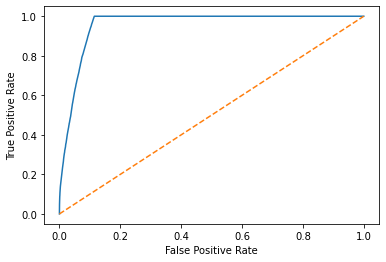

In [119]:
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [120]:
confusion_matrix(y_train, clf_reg.predict(X_train))

array([[73761,  6288],
       [ 7420, 32531]], dtype=int64)

In [121]:
accuracy_score(y_train, clf_reg.predict(X_train))

0.8857666666666667

In [122]:
confusion_matrix(y_test, clf_reg.predict(X_test))

array([[18343,  1608],
       [ 1803,  8246]], dtype=int64)

In [123]:
accuracy_score(y_test, clf_reg.predict(X_test))

0.8863

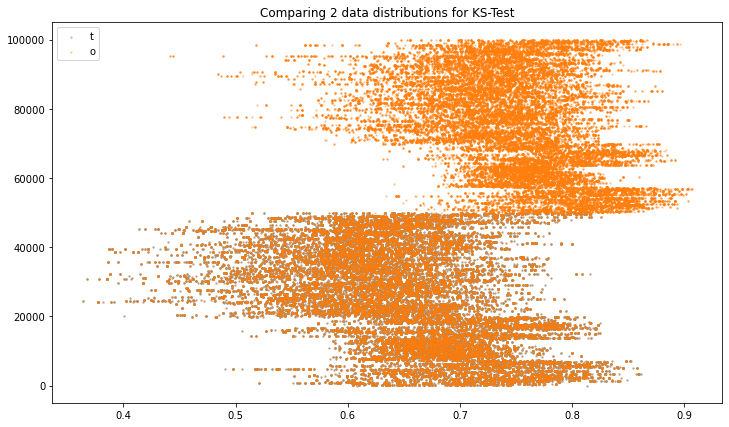

In [124]:
ks_plot_comp(base_loss_values, apgd_mixed)

## Batch Threshold

In [128]:
apgd_clean = apgd_mixed[:len(base_loss_values)]
apgd_attacked = apgd_mixed[len(base_loss_values):]

In [129]:
s1, p1 = batch_pvals(base_loss_values, apgd_clean)
s2, p2 = batch_pvals(base_loss_values, apgd_attacked)

In [130]:
p_cutoff = 0.05
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

1296 1829 2993 132
accuracy:  0.68624


In [131]:
p_cutoff = 0.01
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

1540 1585 2907 218
accuracy:  0.71152


In [132]:
p_cutoff = 0.000001
tn = np.array(p1) > p_cutoff
fp = np.array(p1) <= p_cutoff
tp = np.array(p2) <= p_cutoff
fn = np.array(p2) > p_cutoff

print(sum(tn), sum(fp), sum(tp), sum(fn))
accuracy = (sum(tn) + sum(tp)) / (len(p1) + len(p2))
print("accuracy: ", accuracy)

2387 738 2459 666
accuracy:  0.77536
